# Mushrooms

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_classification import GPC

from sklearn.cluster import KMeans

from vi_svi_class_experiments import run_methods
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Данные

In [7]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets\
/Classification/mushrooms(8124,112).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
y_tr[y_tr == 2] = -1
# exit(0)
data_name = 'mushrooms'

x_tr = x_tr.T
x_tr = x_tr.toarray()
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr)

x_tr = (x_tr + 1) / 2
y_tr = y_tr.reshape((y_tr.size, 1))
x_test = x_tr[:, int(x_tr.shape[1] * 0.8):]
y_test = y_tr[int(x_tr.shape[1] * 0.8):, :]
y_tr = y_tr[:int(x_tr.shape[1] * 0.8), :]
x_tr = x_tr[:, : int(x_tr.shape[1] * 0.8)]
dim, num = x_tr.shape
print('of objects:', num)
print('of features:', dim)
print(data_name)

of objects: 6499
of features: 112
mushrooms


## K-Means cluster centers

In [15]:
ind_num = 50
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [16]:
cov_params = np.array([2., 1., 1.])

## svi-L-BFGS-B-c method

In [17]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
svi_gp = GPC(model_covariance_obj, method='svi')

In [21]:
opts = {'mode': 'full', 'maxiter': 20, 'mydisp': False}
svi_res = svi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

In [22]:
metric = lambda w: svi_gp.get_prediction_quality(w, x_test, y_test)
svi_x_lst, svi_y_lst = svi_res.plot_performance(metric, 't', freq=1)

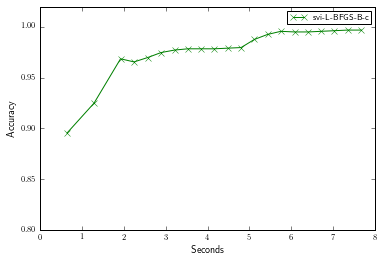

In [25]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.8, 1.02])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## vi-means-c method

In [27]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')

In [49]:
opts = {'maxiter':7, 'mydisp': True}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=5)

Hyper-parameters at iteration 0 : [  1.23719035e+02   1.58614383e+02   1.00000000e-02]
Hyper-parameters at iteration 1 : [  1.25820394e+02   1.57101348e+02   1.00000000e-02]
Hyper-parameters at iteration 2 : [  1.36486631e+02   1.50819247e+02   1.00000000e-02]
Hyper-parameters at iteration 3 : [  1.40287483e+02   1.49741787e+02   1.00000000e-02]
Hyper-parameters at iteration 4 : [  1.41438696e+02   1.49495042e+02   1.00000000e-02]
Hyper-parameters at iteration 5 : [  1.41438935e+02   1.49495133e+02   1.00000000e-02]
Hyper-parameters at iteration 6 : [  1.41493239e+02   1.49494700e+02   1.00000000e-02]
Hyper-parameters at iteration 7 : [  1.41493239e+02   1.49494700e+02   1.00000000e-02]
	Hyper-parameters at outter iteration 0 : [  1.41493239e+02   1.49494700e+02   1.00000000e-02]
Hyper-parameters at iteration 0 : [  1.41493239e+02   1.49494700e+02   1.00000000e-02]
Hyper-parameters at iteration 1 : [  1.41139282e+02   1.50115132e+02   1.00000000e-02]
Hyper-parameters at iteration 2 : [

In [50]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 't', freq=1)

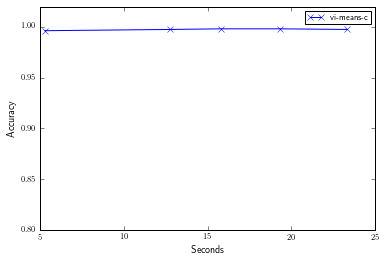

In [51]:
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.8, 1.02])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## svi-AdaDelta-c
Подберем шаг для метода

In [32]:
results = []
steps = [1., 0.5, 0.3, 0.1, 0.01]
for step in steps:
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 5, 'verbose': False, 'batch_size': 50, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)

0
1
2
3
4


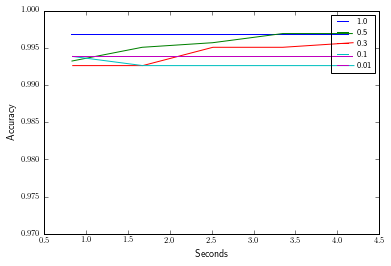

In [35]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):
    svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=1)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
    print(i)
plt.ylim([0.97, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [36]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)
opts = {'mode': 'adadelta', 'maxiter': 10, 'verbose': True, 'batch_size': 50, 
        'step_rate': 1., 'print_freq':1}
batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Iteration  129 :
	Gradient norm 1.08949024817
Iteration  258 :
	Gradient norm 0.791558643679
Iteration  387 :
	Gradient norm 0.634559055699
Iteration  516 :
	Gradient norm 0.817936159442
Iteration  645 :
	Gradient norm 0.551689501616
Iteration  774 :
	Gradient norm 0.552114259728
Iteration  903 :
	Gradient norm 1.80968885872
Iteration  1032 :
	Gradient norm 0.339629376675
Iteration  1161 :
	Gradient norm 0.493524677532
Iteration  1290 :
	Gradient norm 0.831290466513


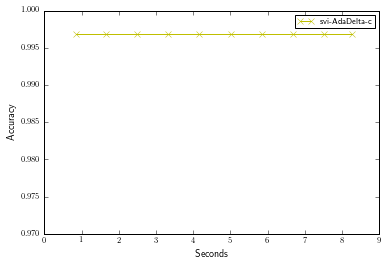

In [37]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
svi_ad_x_lst, svi_ad_y_lst = batch_res.plot_performance(metric, 't', freq=1)
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.ylim([0.97, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## Выводы

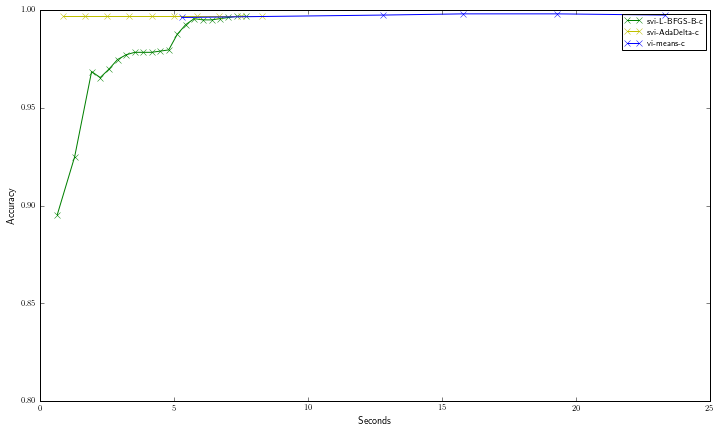

In [52]:
plt.figure(figsize=(12, 7))
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
plt.ylim([0.8, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [53]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_x.npy', svi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_y.npy', svi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_x.npy', vi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_y.npy', vi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_x.npy', svi_ad_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_y.npy', svi_ad_y_lst)